## Transfer Learning with Tensorflow pt.1 : Feature Extraction


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import sklearn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import os 
import pathlib 
import random
import matplotlib.image as mpimg
import zipfile
import wget
import tensorflow_hub as hub

ImportError: cannot import name 'dtensor' from 'tensorflow.compat.v2.experimental' (C:\Users\Ahmed Medhat\AppData\Roaming\Python\Python310\site-packages\tensorflow\_api\v2\compat\v2\experimental\__init__.py)

### Get Helper functions

In [ ]:
import requests
url = "https://raw.githubusercontent.com/Meta-c/Helper-ML/master/ML_functions.py"


In [ ]:
response = requests.get(url)
code = response.text

In [ ]:
exec(code)

### Get data

In [ ]:
# wget.download("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip")

# zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
# zip_ref.extractall()
# zip_ref.close()

In [ ]:
train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

In [ ]:
import pathlib

data_dir = pathlib.Path(train_dir)
class_names=np.array(sorted([item.name for item in data_dir.glob('*')]))

print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_datagen= ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

train_data_10_percent= train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode="categorical")

test_data= test_datagen.flow_from_directory(test_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### Setting up callbacks

In [ ]:
# Create tensorboard callback

import datetime 

def create_tensorboard_callback(dir_name,experiment_name):
    log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving Tensorboard log files to: {log_dir}")
    return tensorboard_callback

## Create Model with Tensorflow hub

In [ ]:
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
def create_model(model_url,num_classes=10):
    # Download pretrained model 
    feature_extractor_layer=hub.KerasLayer(model_url,
                                           trainable=False,
                                        name="feature_extraction_layer",
                                        input_shape=IMAGE_SHAPE+(3,))
    # Create our own model 
    
    model=tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes,activation="softmax")
    ])
    
    return model

### Creating and testing ResNet TensorFlow Hub feature Extraction model

In [ ]:
# Create Resnet model

resnet_model=create_model(resnet_url)

In [ ]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [ ]:
resnet_history=resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
        validation_data=test_data,
        validation_steps=len(test_data),
        # callbacks=[
        #     create_tensorboard_callback(dir_name="tensorflow_hub",
        #                                 experiment_name="resnet50v2"       )]
         )

Saving Tensorboard log files to: tensorflow_hub/resnet50v2/20230313-093130
Epoch 1/5
24/24 [==============================] - 22s 677ms/step - loss: 2.0202 - accuracy: 0.3453 - val_loss: 1.2284 - val_accuracy: 0.6252
Epoch 2/5
24/24 [==============================] - 14s 605ms/step - loss: 0.9340 - accuracy: 0.7360 - val_loss: 0.8904 - val_accuracy: 0.7052
Epoch 3/5
24/24 [==============================] - 15s 647ms/step - loss: 0.6341 - accuracy: 0.8160 - val_loss: 0.7553 - val_accuracy: 0.7524
Epoch 4/5
24/24 [==============================] - 15s 632ms/step - loss: 0.4819 - accuracy: 0.8733 - val_loss: 0.6957 - val_accuracy: 0.7800
Epoch 5/5
24/24 [==============================] - 14s 578ms/step - loss: 0.3881 - accuracy: 0.9013 - val_loss: 0.6679 - val_accuracy: 0.7884


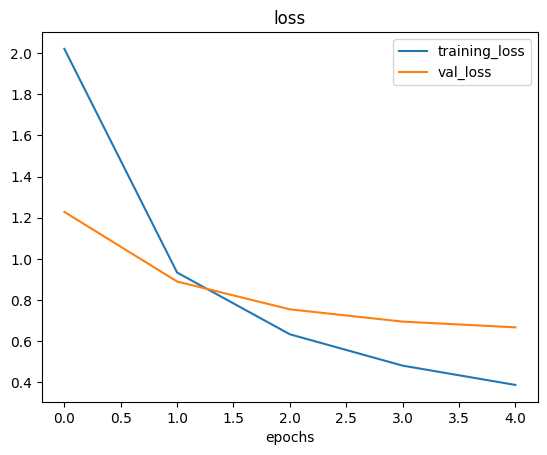

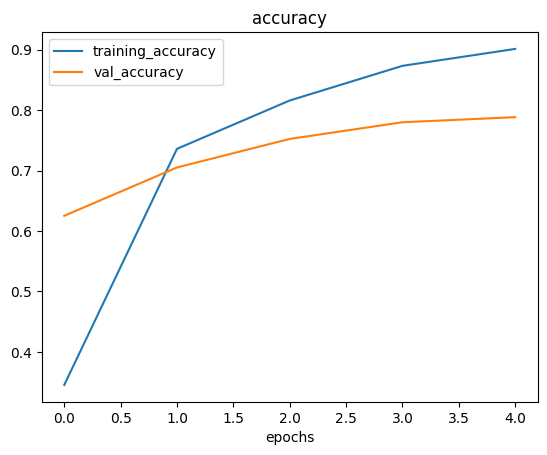

In [ ]:
# plot curves 
plot_loss_curves(resnet_history)   

### Creating and testing EfficientNetB0 Tensorflow Hub Feature Extraction model

In [ ]:
# create model
efficient_model=create_model(efficientnet_url)

In [ ]:
# compile model 
efficient_model.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [ ]:
# fit efficent model 
efficient_history=efficient_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
        validation_data=test_data,
        validation_steps=len(test_data),
        # callbacks=[
        #     create_tensorboard_callback(dir_name="tensorflow_hub",
        #     experiment_name="EfficientNetB0")]
        )

Saving Tensorboard log files to: tensorflow_hub/EfficientNetB0/20230313-100336
Epoch 1/5
24/24 [==============================] - 27s 655ms/step - loss: 1.7973 - accuracy: 0.4907 - val_loss: 1.2375 - val_accuracy: 0.7540
Epoch 2/5
24/24 [==============================] - 12s 508ms/step - loss: 1.0272 - accuracy: 0.7840 - val_loss: 0.8358 - val_accuracy: 0.8232
Epoch 3/5
24/24 [==============================] - 12s 514ms/step - loss: 0.7435 - accuracy: 0.8280 - val_loss: 0.6828 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 12s 512ms/step - loss: 0.5998 - accuracy: 0.8587 - val_loss: 0.6039 - val_accuracy: 0.8560
Epoch 5/5
24/24 [==============================] - 13s 561ms/step - loss: 0.5054 - accuracy: 0.8893 - val_loss: 0.5510 - val_accuracy: 0.8652


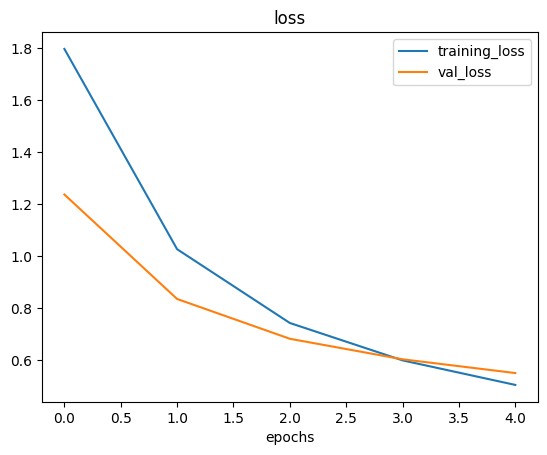

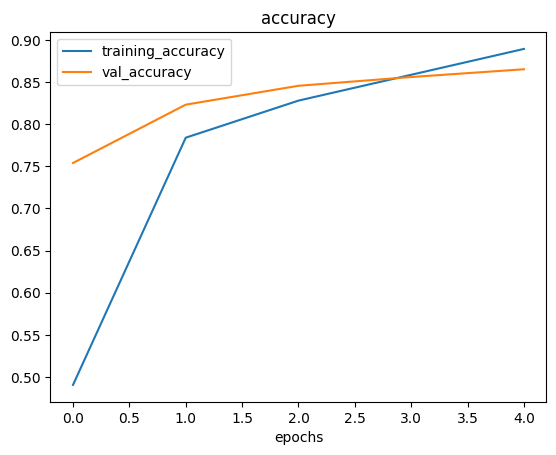

In [ ]:
plot_loss_curves(efficient_history)

### Comparing our models results using tensorboard

In [ ]:
# !tensorboard dev upload --logdir logs \


^C


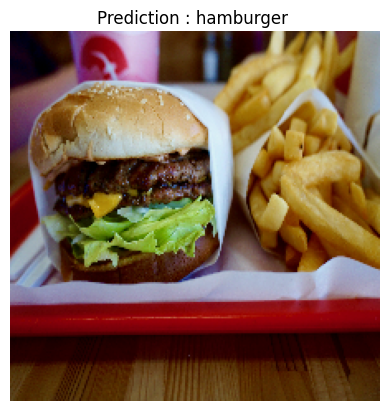

In [ ]:
pred_and_plot(efficient_model,
              filename="03-hamburger.jpeg",image_shape=224,
             class_names=class_names)